# Enabling GPU within your notebook
You will want to enable GPU acceleration within your Colab notebook so that your YOLOv4 system will be able to process detections over 100 times faster than CPU.

### Steps:

### i) Click **Edit** at top left of your notebook
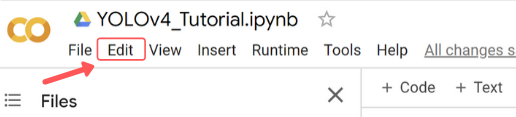
### ii) Click **Notebook Settings** within dropdown
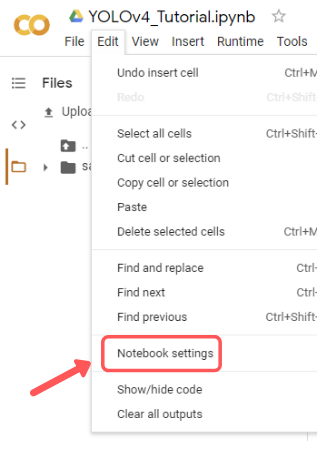
### iii) Under 'Hardware Accelerator' select **GPU** and then hit **Save**
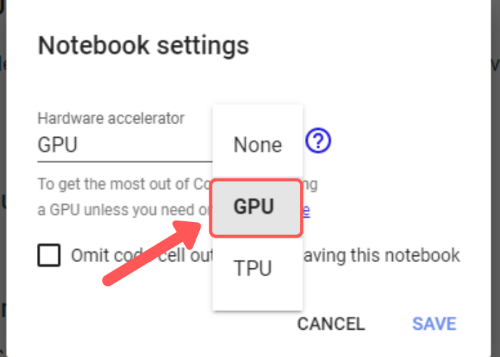

Your notebook should now have GPU enabled!

# Install Dependencies

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import os
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
%matplotlib inline

## Cloning and Setting Up Darknet for YOLOv4
We will be using the famous AlexeyAB's darknet repository to perform YOLOv4 detections.

In [ ]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 14730, done.
remote: Total 14730 (delta 0), reused 0 (delta 0), pack-reused 14730
Receiving objects: 100% (14730/14730), 13.25 MiB | 23.19 MiB/s, done.
Resolving deltas: 100% (10018/10018), done.


In [ ]:
# change makefile to have GPU, OPENCV and LIBSO enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

/content/darknet


In [ ]:
# make darknet (builds darknet so that you can then use the darknet.py file and have its dependencies)
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -fPIC -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:926:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1127:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old ==

In [ ]:
# get bthe scaled yolov4 weights file that is pre-trained to detect 80 classes (objects) from shared google drive
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq" -O yolov4-csp.weights && rm -rf /tmp/cookies.txt

--2021-03-06 14:53:54--  https://docs.google.com/uc?export=download&confirm=8r62&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq
Resolving docs.google.com (docs.google.com)... 74.125.20.139, 74.125.20.100, 74.125.20.113, ...
Connecting to docs.google.com (docs.google.com)|74.125.20.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-0g-docs.googleusercontent.com/docs/securesc/bput0cr40v893tl0uj2d5hu3kn01o1n5/rssj9u3vpbssakpa6sk0ll0hertddvek/1615042425000/17800843676226924807/15371764117047232895Z/1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq?e=download [following]
--2021-03-06 14:53:54--  https://doc-04-0g-docs.googleusercontent.com/docs/securesc/bput0cr40v893tl0uj2d5hu3kn01o1n5/rssj9u3vpbssakpa6sk0ll0hertddvek/1615042425000/17800843676226924807/15371764117047232895Z/1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq?e=download
Resolving doc-04-0g-docs.googleusercontent.com (doc-04-0g-docs.googleusercontent.com)... 142.250.107.132, 2607:f8b0:400e:c0d::84
Connecting to

## Darknet for Python
In order to utilize YOLOv4 with Python code we will use some of the pre-built functions found within darknet.py by importing the functions into our workstation. Feel free to checkout the darknet.py file to see the function definitions in detail! 

In [ ]:
# import darknet functions to perform object detections
from darknet import *
# load in our YOLOv4 architecture network
network, class_names, class_colors = load_network("cfg/yolov4-csp.cfg", "cfg/coco.data", "yolov4-csp.weights")
width = network_width(network)
height = network_height(network)

# darknet helper function to run detection on image
def darknet_helper(img, width, height):
  darknet_image = make_image(width, height, 3)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_resized = cv2.resize(img_rgb, (width, height),
                              interpolation=cv2.INTER_LINEAR)

  # get image ratios to convert bounding boxes to proper size
  img_height, img_width, _ = img.shape
  width_ratio = img_width/width
  height_ratio = img_height/height

  # run model on darknet style image to get detections
  copy_image_from_bytes(darknet_image, img_resized.tobytes())
  detections = detect_image(network, class_names, darknet_image)
  free_image(darknet_image)
  return detections, width_ratio, height_ratio

## YOLOv4 Example on Test Image
Let's make sure our model has successfully been loaded and that we can make detections properly on a test image.

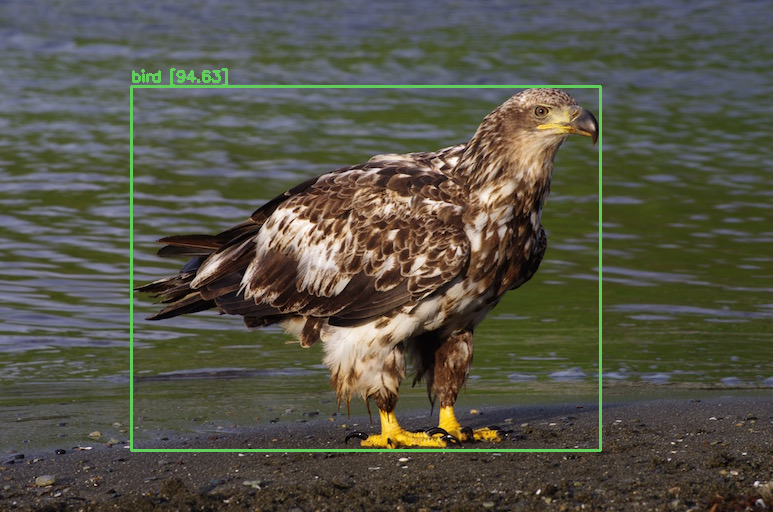

In [ ]:
# run test on dog.jpg image that comes with repository
image = cv2.imread("data/dog.jpg")
detections, width_ratio, height_ratio = darknet_helper(image, width, height)

for label, confidence, bbox in detections:
  left, top, right, bottom = bbox2points(bbox)
  left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
  cv2.rectangle(image, (left, top), (right, bottom), class_colors[label], 2)
  cv2.putText(image, "{} [{:.2f}]".format(label, float(confidence)),
                    (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    class_colors[label], 2)
cv2_imshow(image)

# Mounting Google Drive
You can mount your Google Drive files by running the following code snippet:


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# SORT : Simple Object Real-time Tracking

Let's copy SORT code (sort.py) into darknet folder:

In [ ]:
!cp "/content/drive/MyDrive/sort.py" -r "/content/darknet"

Importing SORT:

In [ ]:
!pip install filterpy
from sort import *
mot_tracker    = Sort(max_age=25, min_hits=4, iou_threshold=0.3)

     |████████████████████████████████| 184kB 8.6MB/s 
  Created wheel for filterpy: filename=filterpy-1.4.5-cp37-none-any.whl size=110452 sha256=719b3182d0b2ec4b0331c9475db28d4e2276f719c187153671c017909005acda
  Stored in directory: /root/.cache/pip/wheels/c3/0c/dd/e92392c3f38a41371602d99fc77d6c1d42aadbf0c6afccdd02
Successfully built filterpy


# Input Setting : Oxford Town Center
https://exposing.ai/oxford_town_centre/

Then copy them to Darknet folder:

In [ ]:
!cp "/content/drive/MyDrive/OxfordTownCentreDataset.avi" -r "/content/darknet"

In [ ]:
Input            = "./OxfordTownCentreDataset.avi"
ReductionFactor  = 2
calibration      = [[180,162],[618,0],[552,540],[682,464]]

# DeepSOCIAL 

In [ ]:
!cp "/content/drive/MyDrive/deepsocial.pyc" -r "/content/darknet"

Configration :

In [ ]:
from deepsocial import *

######################## Frame number
StartFrom  = 0 
EndAt      = 500                       #-1 for the end of the video
######################## (0:OFF/ 1:ON) Outputs
CouplesDetection    = 1                # Enable Couple Detection 
DTC                 = 1                # Detection, Tracking and Couples 
SocialDistance      = 1
CrowdMap            = 1
# MoveMap             = 0
# ViolationMap        = 0             
# RiskMap             = 0
######################## Units are Pixel
ViolationDistForIndivisuals = 28 
ViolationDistForCouples     = 31
####
CircleradiusForIndivsual    = 14
CircleradiusForCouples      = 17
######################## 
MembershipDistForCouples    = (16 , 10) # (Forward, Behind) per Pixel
MembershipTimeForCouples    = 35        # Time for considering as a couple (per Frame)
######################## (0:OFF/ 1:ON)
CorrectionShift  = 1                    # Ignore people in the margins of the video
HumanHeightLimit = 200                  # Ignore people with unusual heights
########################
Transparency        = 0.7
######################## Output Video's path
Path_For_DTC = os.getcwd() + "/DeepSOCIAL DTC.avi"
Path_For_SocialDistance = os.getcwd() + "/DeepSOCIAL Social Distancing.avi"
Path_For_CrowdMap = os.getcwd() + "/DeepSOCIAL Crowd Map.avi"

In [ ]:
def extract_humans(detections):
    detetcted = []
    if len(detections) > 0: # At least 1 detection in the image and check detection presence in a frame  
        idList = []
        id = 0
        for label, confidence, bbox in detections:
            if label == 'person': 
                xmin, ymin, xmax, ymax = bbox2points(bbox)
                id +=1
                if id not in idList: idList.append(id)
                detetcted.append([int(xmin), int(ymin), int(xmax), int(ymax), idList[-1]])
    return np.array(detetcted)

def centroid(detections, image, calibration, _centroid_dict, CorrectionShift, HumanHeightLimit):
    e = birds_eye(image.copy(), calibration)
    centroid_dict = dict()
    now_present = list()
    if len(detections) > 0:   
        for d in detections:
            p = int(d[4])
            now_present.append(p)
            xmin, ymin, xmax, ymax = d[0], d[1], d[2], d[3]
            w = xmax - xmin
            h = ymax - ymin
            x = xmin + w/2
            y = ymax - h/2
            if h < HumanHeightLimit:
                overley = e.image
                bird_x, bird_y = e.projection_on_bird((x, ymax))
                if CorrectionShift:
                    if checkupArea(overley, 1, 0.25, (x, ymin)):
                        continue
                e.setImage(overley)
                center_bird_x, center_bird_y = e.projection_on_bird((x, ymin))
                centroid_dict[p] = (
                            int(bird_x), int(bird_y),
                            int(x), int(ymax), 
                            int(xmin), int(ymin), int(xmax), int(ymax),
                            int(center_bird_x), int(center_bird_y))

                _centroid_dict[p] = centroid_dict[p]
    return _centroid_dict, centroid_dict, e.image

def ColorGenerator(seed=1, size=10):
    np.random.seed = seed
    color=dict()
    for i in range(size):
        h = int(np.random.uniform() *255)
        color[i]= h
    return color

def VisualiseResult(_Map, e):
    Map = np.uint8(_Map)
    histMap = e.convrt2Image(Map)
    visualBird = cv2.applyColorMap(np.uint8(_Map), cv2.COLORMAP_JET)
    visualMap = e.convrt2Image(visualBird)
    visualShow = cv2.addWeighted(e.original, 0.7, visualMap, 1 - 0.7, 0)
    return visualShow, visualBird, histMap

In [ ]:
cap = cv2.VideoCapture(Input)
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
height, width = frame_height // ReductionFactor, frame_width // ReductionFactor
print("Video Reolution: ",(width, height))

if DTC: DTCVid = cv2.VideoWriter(Path_For_DTC, cv2.VideoWriter_fourcc(*"MJPG"), 30.0, (width, height))
if SocialDistance: SDimageVid = cv2.VideoWriter(Path_For_SocialDistance, cv2.VideoWriter_fourcc(*"MJPG"), 30.0, (width, height))
if CrowdMap: CrowdVid = cv2.VideoWriter(Path_For_CrowdMap, cv2.VideoWriter_fourcc(*"XVID"), 30.0, (width, height))

colorPool = ColorGenerator(size = 3000)
_centroid_dict = dict()
_numberOFpeople = list()
_greenZone = list()
_redZone = list()
_yellowZone = list()
_final_redZone = list()
_relation = dict()
_couples = dict()
_trackMap = np.zeros((height, width, 3), dtype=np.uint8)
_crowdMap = np.zeros((height, width), dtype=np.int) 
_allPeople = 0
_counter = 1
frame = 0

while True:
    print('-- Frame : {}'.format(frame))
    prev_time = time.time()
    ret, frame_read = cap.read()
    if not ret: break

    frame += 1
    if frame <= StartFrom: continue
    if frame != -1:
        if frame > EndAt: break
        
    frame_resized = cv2.resize(frame_read,(width, height), interpolation=cv2.INTER_LINEAR)
    image = frame_resized
    e = birds_eye(image, calibration)
    detections, width_ratio, height_ratio = darknet_helper(image, width, height)
    humans = extract_humans(detections)
    track_bbs_ids = mot_tracker.update(humans) if len(humans) != 0 else humans

    _centroid_dict, centroid_dict, partImage = centroid(track_bbs_ids, image, calibration, _centroid_dict, CorrectionShift, HumanHeightLimit)
    redZone, greenZone = find_zone(centroid_dict, _greenZone, _redZone, criteria=ViolationDistForIndivisuals)
    
    if CouplesDetection:
        _relation, relation = find_relation(e, centroid_dict, MembershipDistForCouples, redZone, _couples, _relation)
        _couples, couples, coupleZone = find_couples(image, _centroid_dict, relation, MembershipTimeForCouples, _couples)
        yellowZone, final_redZone, redGroups = find_redGroups(image, centroid_dict, calibration, ViolationDistForCouples, redZone, coupleZone, couples , _yellowZone, _final_redZone)
    else:
        couples = []
        coupleZone = []
        yellowZone = []
        redGroups = redZone
        final_redZone = redZone


    if DTC:
        DTC_image = image.copy()
        _trackMap = Apply_trackmap(centroid_dict, _trackMap, colorPool, 3)
        DTC_image = cv2.add(e.convrt2Image(_trackMap), image) 
        DTCShow = DTC_image
        for id, box in centroid_dict.items():
            center_bird = box[0], box[1]
            if not id in coupleZone:
                cv2.rectangle(DTCShow,(box[4], box[5]),(box[6], box[7]),(0,255,0),2)
                cv2.rectangle(DTCShow,(box[4], box[5]-13),(box[4]+len(str(id))*10, box[5]),(0,200,255),-1)
                cv2.putText(DTCShow,str(id),(box[4]+2, box[5]-2),cv2.FONT_HERSHEY_SIMPLEX,.4,(0,0,0),1,cv2.LINE_AA)
        for coupled in couples:
            p1 , p2 = coupled
            couplesID = couples[coupled]['id']
            couplesBox = couples[coupled]['box']
            cv2.rectangle(DTCShow, couplesBox[2:4], couplesBox[4:], (0,150,255), 4)
            loc = couplesBox[0] , couplesBox[3]
            offset = len(str(couplesID)*5)
            captionBox = (loc[0] - offset, loc[1]-13), (loc[0] + offset, loc[1])
            cv2.rectangle(DTCShow,captionBox[0],captionBox[1],(0,200,255),-1)
            wc = captionBox[1][0] - captionBox[0][0]
            hc = captionBox[1][1] - captionBox[0][1]
            cx = captionBox[0][0] + wc // 2
            cy = captionBox[0][1] + hc // 2
            textLoc = (cx - offset, cy + 4)
            cv2.putText(DTCShow, str(couplesID) ,(textLoc),cv2.FONT_HERSHEY_SIMPLEX,.4,(0,0,0),1,cv2.LINE_AA)
        DTCVid.write(DTCShow)


    if SocialDistance:
        SDimage, birdSDimage = Apply_ellipticBound(centroid_dict, image, calibration, redZone, greenZone, yellowZone, final_redZone, coupleZone, couples, CircleradiusForIndivsual, CircleradiusForCouples)
        SDimageVid.write(SDimage)


    if CrowdMap:
        _crowdMap, crowdMap = Apply_crowdMap(centroid_dict, image, _crowdMap)
        crowd = (crowdMap - crowdMap.min()) / (crowdMap.max() - crowdMap.min())*255
        crowd_visualShow, crowd_visualBird, crowd_histMap = VisualiseResult(crowd, e)
        CrowdVid.write(crowd_visualShow)


    cv2.waitKey(3)
print('::: Analysis Completed')

cap.release()
if DTC: DTCVid.release(); print("::: Video Write Completed : ", Path_For_DTC)
if SocialDistance: SDimageVid.release() ; print("::: Video Write Completed : ", Path_For_SocialDistance)
if CrowdMap: CrowdVid.release() ; print("::: Video Write Completed : ", Path_For_CrowdMap)


Video Reolution:  (960, 540)
-- Frame : 0
-- Frame : 1
-- Frame : 2
-- Frame : 3
-- Frame : 4
-- Frame : 5
-- Frame : 6
-- Frame : 7
-- Frame : 8
-- Frame : 9
-- Frame : 10
-- Frame : 11
-- Frame : 12
-- Frame : 13
-- Frame : 14
-- Frame : 15
-- Frame : 16
-- Frame : 17
-- Frame : 18
-- Frame : 19
-- Frame : 20
-- Frame : 21
-- Frame : 22
-- Frame : 23
-- Frame : 24
-- Frame : 25
-- Frame : 26
-- Frame : 27
-- Frame : 28
-- Frame : 29
-- Frame : 30
-- Frame : 31
-- Frame : 32
-- Frame : 33
-- Frame : 34
-- Frame : 35
-- Frame : 36
-- Frame : 37
-- Frame : 38
-- Frame : 39
-- Frame : 40
-- Frame : 41
-- Frame : 42
-- Frame : 43
-- Frame : 44
-- Frame : 45
-- Frame : 46
-- Frame : 47
-- Frame : 48
-- Frame : 49
-- Frame : 50
::: Analysis Completed
::: Video Write Completed :  /content/darknet/DeepSOCIAL DTC.avi
::: Video Write Completed :  /content/darknet/DeepSOCIAL Social Distancing.avi
::: Video Write Completed :  /content/darknet/DeepSOCIAL Crowd Map.avi
